# Wumpus World Unity Environment Log Analysis

This notebook contains our analysis of performance logs from different AI agent implementations in the Wumpus World Unity environment.

We compare execution times and behavioral patterns across multiple scenarios with varying complexity.

## Context

The analysis focuses on different AI types including:
- Basic Rule-based agents
- Finite State Machine agents
- Behavior Tree agents
- Prolog agents
- Prolog Meta Interpreter agents

Each scenario uses different configurations of world size, number of agents, and dangers (pits and Wumpus) distribution.

Common parameters across all configurations:
| Parameter | Value |
|:----------|:------|
| **randomSeed** | 1 |
| **nbGold** | 1 |
| **nbAgent** | [1, 5, 10] |
| **aiType** | [Basic, FiniteStateMachine, BehaviorTree, Prolog, PrologMetaInterpreter] |
| **personalities** | [(cupid & brave), (ascetic & coward), (cupid & coward)] |

The decision logic is the same across all AI implementations, leading to the same exploration patterns.

There are very small differences in step counts due to the way the AI types are implemented and the actions taken are collected.

### Grid-Specific Configurations

| Grid Size | Number of Pits & Wumpus |
|:---------:|:-------------:|
| 10x10     | 3          |
| 15x15     | 7          |
| 20x20     | 12         |
| 25x25     | 19         |
| 30x30     | 27         |
| 50x50     | 75         |
| 100x100   | 300        |

We have 7 grid sizes, 3 personality sets, 5 AI types, and 3 agent numbers.

So, there are `7*3*5*3=315` configurations.

#### Prolog Meta Interpreter Limitations
We have 45 files for 10x10, 15x15, 20x20, and 25x25 grids, but only 36 files for 30x30, 50x50, and 100x100 grids because the Prolog Meta Interpreter agent algorithm was too heavy on resources making Unity crash.

Then, to be fair in the analysis, we will only consider the first 4 grid sizes (10x10, 15x15, 20x20, and 25x25).

### Data Collection

Files are stored in the `data` directory (same as this file). The data is organized in subdirectories based on the grid size:
- 10x10
- 15x15
- 20x20
- 25x25
- 30x30
- 50x50
- 100x100

Each json file follows the naming convention:
```
<grid_size>_<nb_agents>_<nb_wumpus_pits>_<nb_gold>_<personality1>_<personality2>_<ai_type>.json
```

For example, for a 10x10 grid with 1 agent, 3 wumpus, 3 pits, and 1 gold, using the Cupid and Coward personalities with a Basic AI type, the file would be in folder `10x10` under the name:
```
10x10/10x10-1a-3wp-1g-Cupid-Coward-Basic.json
```

### Data Structure

Each JSON file contains an array with two objects:

1. **Game Configuration and Performance Data**:
    - `randomSeed`: The seed used for randomization
    - `gridMin` & `gridMax`: Boundaries of the grid
    - `tileSize`: Size of each tile
    - `nbPit`, `nbWumpus`, `nbGold`: Number of pits, wumpuses, and gold
    - `nbAgent`: Number of agents
    - `aiType`: Type of AI used (Basic, Prolog, BehaviourTree, etc.)
    - `personalities`: Array of personality type IDs
    - `isGameOver`: Whether the game has ended
    - `isModeAuto`: Whether the game is running in automatic mode
    - `turnDuration`: Array of turn durations in milliseconds

2. **Agent Behavior Data**:
    - `agent`: Agent identifier
    - `actions`: Array of actions taken by the agent
    - `positions`: Array of position objects, with x,y coordinates for each turn

See [10x10/10x10-1a-3wp-1g-Cupid-Coward-Basic.json](10x10/10x10-1a-3wp-1g-Cupid-Coward-Basic.json) for an example of the data structure.

## 1. Baseline Performance Analysis

This section focuses on analyzing the performance of different AI agent implementations within the Wumpus World environment. We begin by processing JSON log files from an `?x?` grid size scenarios to establish baseline performance metrics.

Key metrics analyzed in this section:
- **Turn Duration**: The average time each agent takes to decide and execute an action, measured in milliseconds
- **Total Execution Time**: The cumulative time for the entire execution of the game, from start to finish
- **Steps Taken**: The total number of movements made by agents

The analysis compares these metrics across:
1. Different AI types (Basic, Finite State Machine, Behavior Tree, Prolog, Prolog Meta Interpreter)
2. Varying numbers of agents (1, 5, 10)
3. Different personality combinations (Cupid-Brave, Ascetic-Coward, Cupid-Coward)

The visualizations reveal performance patterns and trade-offs between different agent implementations, with particular focus on computational efficiency and exploration strategies.

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
import seaborn as sns
from glob import glob


# Keep the existing functions
def load_json_data(file_path):
    """Load data from a JSON file."""
    with open(file_path, "r") as f:
        return json.load(f)


def get_turn_duration_stats(data):
    """Extract turn duration statistics from game data."""
    turn_durations = data[0]["turnDuration"]
    return {
        "mean": np.mean(turn_durations),
        "median": np.median(turn_durations),
        "min": np.min(turn_durations),
        "max": np.max(turn_durations),
        "std": np.std(turn_durations),
        "total": np.sum(turn_durations),
        "count": len(turn_durations),
    }


def analyze_agent_actions(data):
    """Analyze the frequency of different actions taken by agent."""
    actions = data[1]["actions"]
    action_counts = {}
    for action in actions:
        if action in action_counts:
            action_counts[action] += 1
        else:
            action_counts[action] = 1
    return action_counts


# Define function to calculate movement efficiency
def calculate_movement_efficiency(positions):
    total_steps = len(positions) - 1
    unique_positions = len(set((pos["x"], pos["y"]) for pos in positions))
    return {
        "total_steps": total_steps,
        "unique_positions": unique_positions
    }


# Function to parse file name to extract metadata
def parse_filename(filename):
    # Using regex to extract parts from filename
    pattern = r"(\d+)x\d+-(\d+)a-\d+wp-\d+g-(\w+)-(\w+)-(\w+).json"
    match = re.search(pattern, filename)
    if match:
        grid_size = match.group(1)
        num_agents = match.group(2)
        trait1 = match.group(3)
        trait2 = match.group(4)
        ai_type = match.group(5)
        return {
            "grid_size": int(grid_size),
            "num_agents": int(num_agents),
            "trait1": trait1,
            "trait2": trait2,
            "ai_type": ai_type,
            "personality": f"{trait1}-{trait2}",
        }
    return None


# Load data from all grid sizes
all_data = {}
metadata = []

# Process files from all grid sizes
for grid_size in [10, 15, 20, 25]:
    # Use glob to find all .json files in each grid size directory
    grid_file_paths = glob(f"{grid_size}x{grid_size}/*.json")
    
    # Sort the file paths for consistent processing
    grid_file_paths.sort()
    
    print(f"Found {len(grid_file_paths)} files in {grid_size}x{grid_size} directory")
    
    # Process files and extract metadata
    for file_path in grid_file_paths:
        meta = parse_filename(file_path)
        if meta:
            data = load_json_data(file_path)

            # Collect stats
            turn_stats = get_turn_duration_stats(data)
            action_counts = analyze_agent_actions(data)
            movement_efficiency = calculate_movement_efficiency(data[1]["positions"])

            # Store all info
            file_key = (
                f"{meta['grid_size']}x{meta['grid_size']}-{meta['num_agents']}a-{meta['trait1']}-{meta['trait2']}-{meta['ai_type']}"
            )
            all_data[file_key] = {
                "data": data,
                "meta": meta,
                "stats": {
                    "turn_stats": turn_stats,
                    "action_counts": action_counts,
                    "movement_efficiency": movement_efficiency,
                },
            }

            # Add stats to metadata for DataFrame
            meta_entry = {
                **meta,
                "mean_turn": turn_stats["mean"],
                "median_turn": turn_stats["median"],
                "max_turn": turn_stats["max"],
                "total_time": turn_stats["total"],
                "steps": movement_efficiency["total_steps"],
                "actions": len(action_counts)
            }
            metadata.append(meta_entry)

# Create DataFrame for easier analysis
df = pd.DataFrame(metadata)
print(f"Processed a total of {len(metadata)} files across all grid sizes")
print(f"Grid sizes in dataset: {[int(size) for size in sorted(df['grid_size'].unique())]}")
print(f"AI types in dataset: {sorted(df['ai_type'].unique())}")
print(f"Personalities in dataset: {sorted(df['personality'].unique())}")

Found 45 files in 10x10 directory
Found 45 files in 15x15 directory
Found 45 files in 20x20 directory
Found 45 files in 25x25 directory
Processed a total of 180 files across all grid sizes
Grid sizes in dataset: [10, 15, 20, 25]
AI types in dataset: ['Basic', 'BehaviourTree', 'FiniteStateMachine', 'Prolog', 'PrologMetaInterpreter']
Personalities in dataset: ['Ascetic-Coward', 'Cupid-Brave', 'Cupid-Coward']


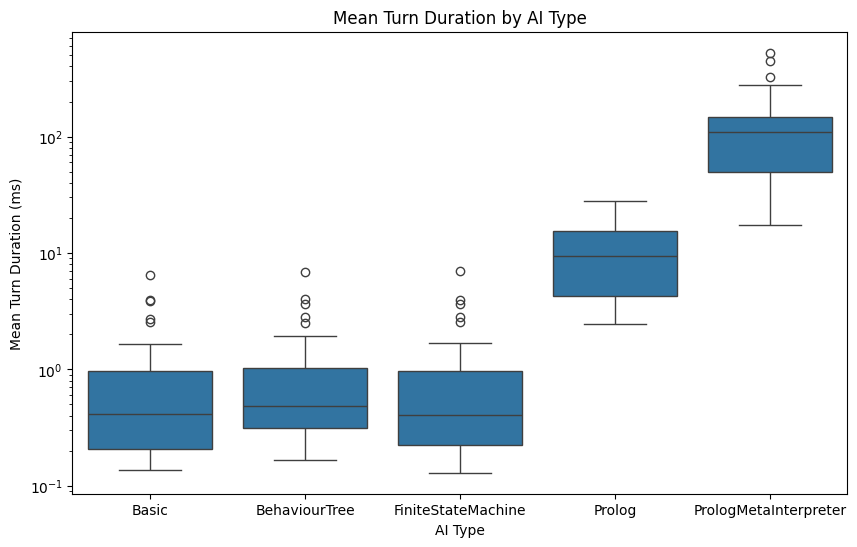

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="ai_type", y="mean_turn", data=df)
plt.title("Mean Turn Duration by AI Type")
plt.yscale("log")
plt.xlabel("AI Type")
plt.ylabel("Mean Turn Duration (ms)")
plt.savefig('./figures/ai_type_mean_turn.pdf')
plt.show()

### Mean Turn Duration by AI Type
The boxplot above compares the distribution of average decision times across different AI implementations. 
- **Basic / FSM / BT** agents cluster around ~1 ms.
- **Prolog** is slower (~10 ms).
- **Meta‐Interpreter** peaks around ~128 ms.

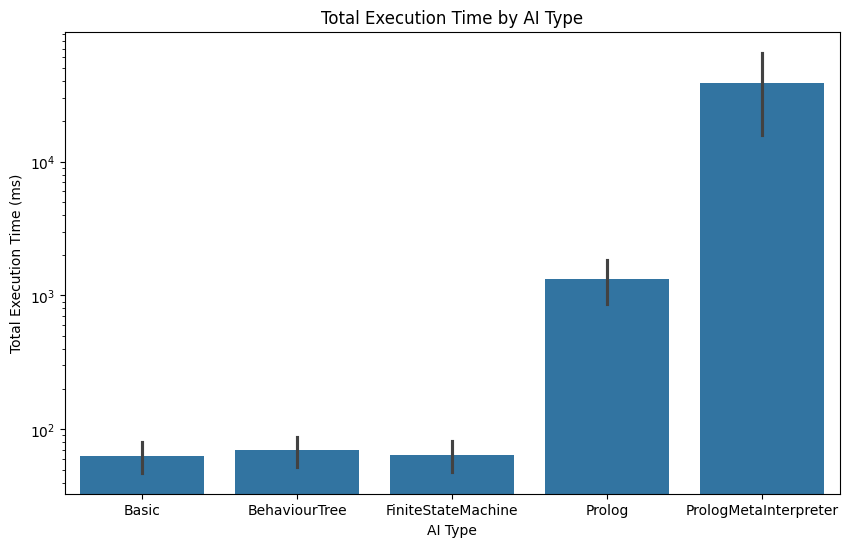

In [34]:
plt.figure(figsize=(10, 6))
sns.barplot(x="ai_type", y="total_time", data=df)
plt.title("Total Execution Time by AI Type")
plt.yscale("log")
plt.xlabel("AI Type")
plt.ylabel("Total Execution Time (ms)")
plt.savefig('./figures/ai_type_total_time.pdf')
plt.show()

### Total Execution Time by AI Type
This bar chart shows cumulative processing time per AI type. Prolog variants take substantially longer overall compared to rule‑based and behavior‑tree agents.

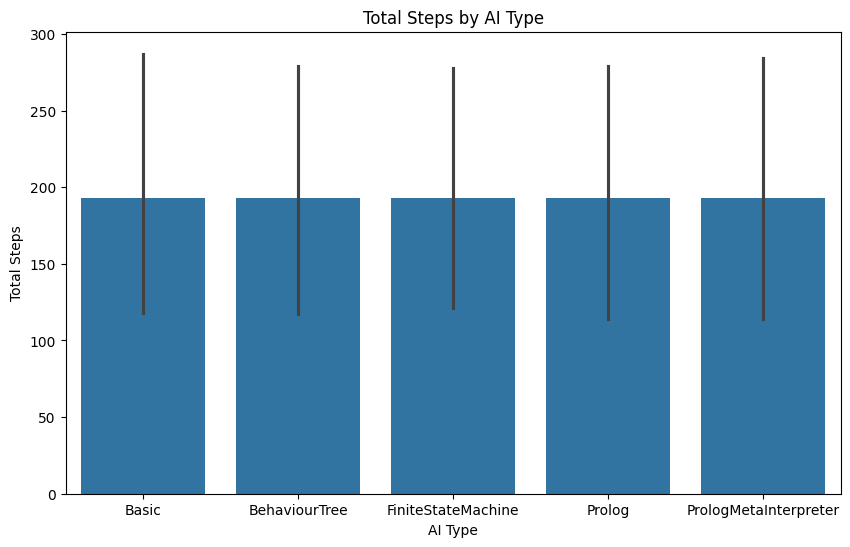

In [36]:
plt.figure(figsize=(10, 6))
sns.barplot(x="ai_type", y="steps", data=df)
plt.title("Total Steps by AI Type")
plt.xlabel("AI Type")
plt.ylabel("Total Steps")
plt.savefig('./figures/ai_type_steps.pdf')
plt.show()

### Total Steps by AI Type
Agents across all implementations traverse a similar number of tiles (~193), confirming identical exploration logic.

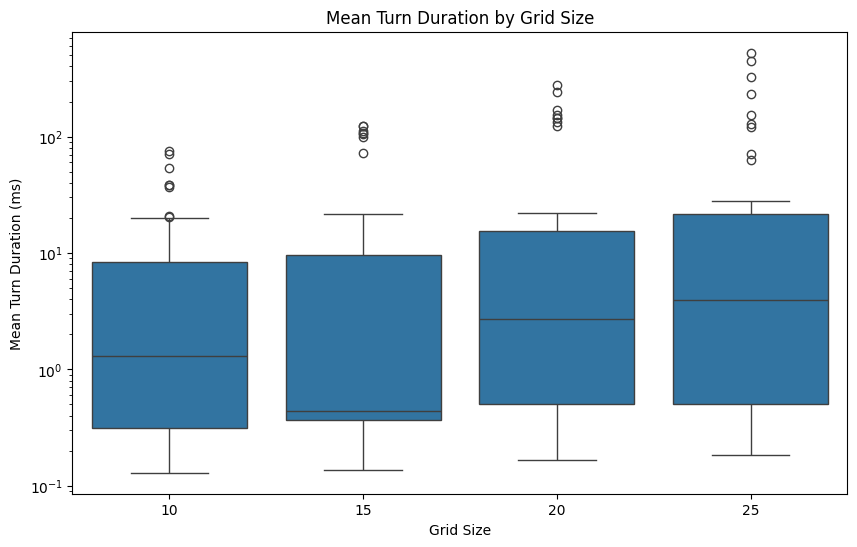

In [6]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="grid_size", y="mean_turn", data=df)
plt.title("Mean Turn Duration by Grid Size")
plt.yscale("log")
plt.xlabel("Grid Size")
plt.ylabel("Mean Turn Duration (ms)")
plt.savefig('./figures/grid_size_mean_turn.pdf')
plt.show()

### Mean Turn Duration by Grid Size
The boxplot above shows how the average decision time varies with grid size. Larger grids tend to increase decision times.

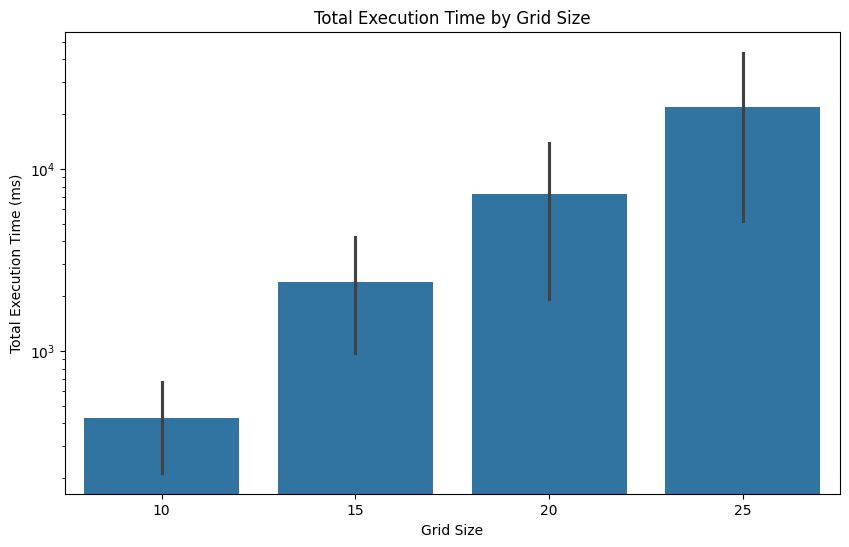

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x="grid_size", y="total_time", data=df)
plt.title("Total Execution Time by Grid Size")
plt.yscale("log")
plt.xlabel("Grid Size")
plt.ylabel("Total Execution Time (ms)")
plt.savefig('./figures/grid_size_total_time.pdf')
plt.show()

### Total Execution Time by Grid Size
This bar chart shows the cumulative processing time for different grid sizes. Larger grids require more processing time.

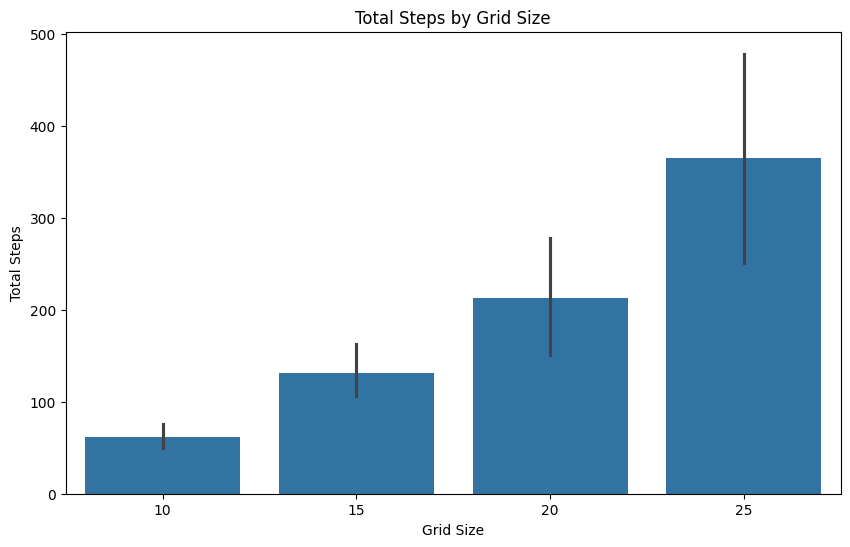

In [40]:
plt.figure(figsize=(10, 6))
sns.barplot(x="grid_size", y="steps", data=df)
plt.title("Total Steps by Grid Size")
plt.xlabel("Grid Size")
plt.ylabel("Total Steps")
plt.savefig('./figures/grid_size_steps.pdf')
plt.show()

### Total Steps by Grid Size
The bar chart above shows the total number of steps taken by agents in different grid sizes. Larger grids require more steps.

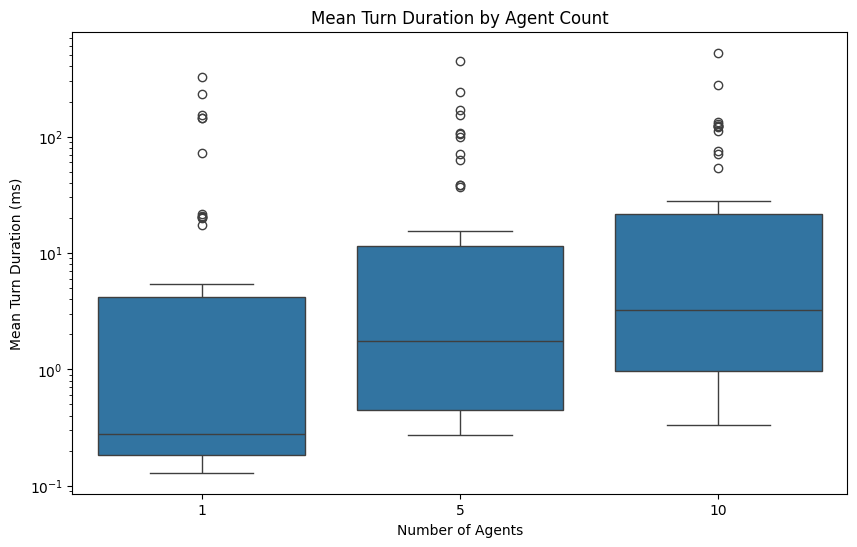

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="num_agents", y="mean_turn", data=df)
plt.title("Mean Turn Duration by Agent Count")
plt.yscale("log")
plt.xlabel("Number of Agents")
plt.ylabel("Mean Turn Duration (ms)")
plt.savefig('./figures/agent_count_mean_turn.pdf')
plt.show()

### Mean Turn Duration by Agent Count
The boxplot above shows how the average decision time varies with the number of agents. More agents tend to reduce decision times.

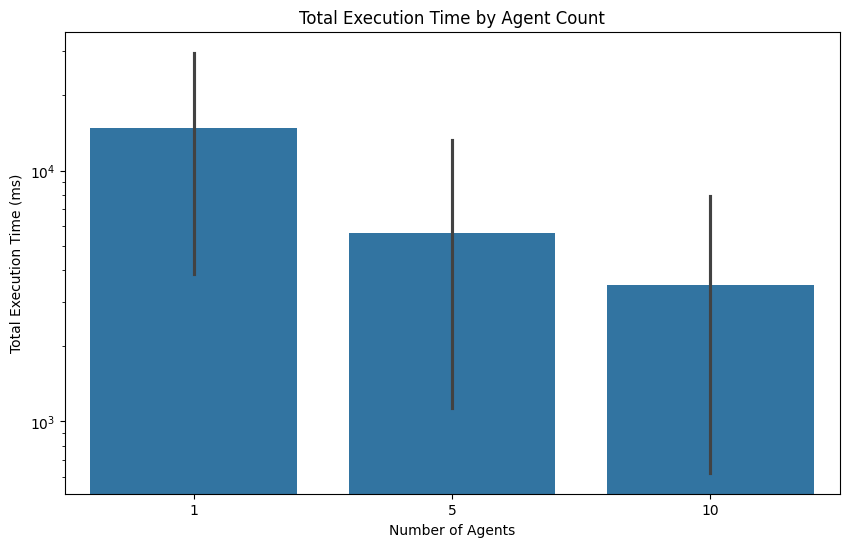

In [10]:
plt.figure(figsize=(10, 6))
sns.barplot(x="num_agents", y="total_time", data=df)
plt.title("Total Execution Time by Agent Count")
plt.yscale("log")
plt.xlabel("Number of Agents")
plt.ylabel("Total Execution Time (ms)")
plt.savefig('./figures/agent_count_total_time.pdf')
plt.show()

### Total Execution Time by Agent Count
This bar chart shows the cumulative processing time for different numbers of agents. More agents tend to reduce total processing time.

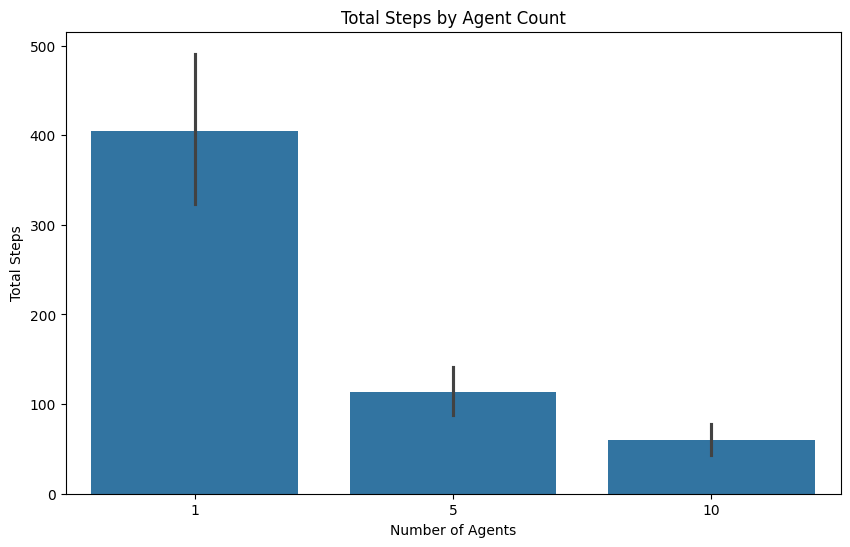

In [11]:
plt.figure(figsize=(10, 6))
sns.barplot(x="num_agents", y="steps", data=df)
plt.title("Total Steps by Agent Count")
plt.xlabel("Number of Agents")
plt.ylabel("Total Steps")
plt.savefig('./figures/agent_count_steps.pdf')
plt.show()

### Total Steps by Agent Count
The bar chart above shows the total number of steps taken by different numbers of agents. More agents tend to reduce the total number of steps.

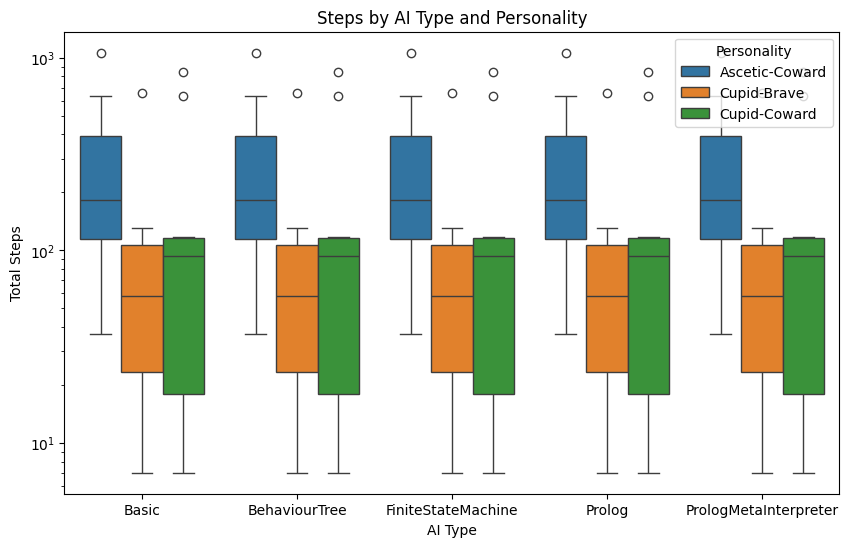

In [35]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="ai_type", y="steps", hue="personality", data=df)
plt.title("Steps by AI Type and Personality")
plt.yscale("log")
plt.xlabel("AI Type")
plt.ylabel("Total Steps")
plt.legend(title="Personality", loc="upper right")
plt.savefig('./figures/interaction_ai_personality.pdf')
plt.show()

### Steps by AI Type and Personality
The boxplot above shows the interaction between AI type and personality on the total number of steps taken. Different personality traits influence the exploration behavior of agents.

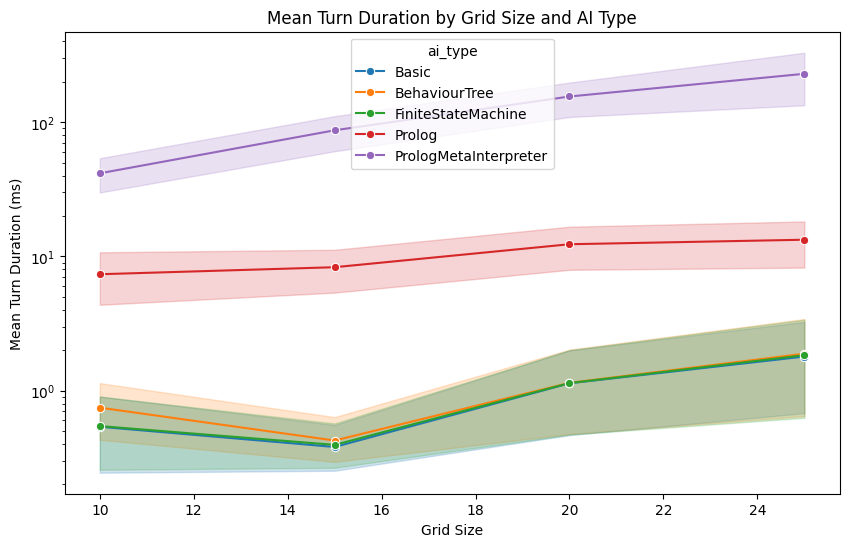

In [13]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="grid_size", y="mean_turn", hue="ai_type", data=df, marker="o")
plt.title("Mean Turn Duration by Grid Size and AI Type")
plt.yscale("log")
plt.xlabel("Grid Size")
plt.ylabel("Mean Turn Duration (ms)")
plt.savefig('./figures/interaction_grid_ai.pdf')
plt.show()

### Mean Turn Duration by Grid Size and AI Type
The line plot above shows the interaction between grid size and AI type on the average decision time. Larger grids and more complex AI types tend to increase decision times.

In [51]:
print("Summary of Performance Metrics by AI Type:")
ai_summary = (
    df.groupby("ai_type")
    .agg(
        {
            "mean_turn":   "mean",
            "median_turn": "mean",
            "total_time":  "mean",
            "steps":       "mean",
        }
    )
    .reset_index()
)
ai_summary = ai_summary.rename(
    columns={
        "ai_type": "AI Type",
        "mean_turn": "Mean Turn Duration (ms)",
        "median_turn": "Median Turn Duration (ms)",
        "total_time": "Mean Execution Time (ms)",
        "steps": "Mean Steps",
    }
)
print(ai_summary.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

print("\nSummary for Mean Turn Duration by Grid Size:")
mean_grid_summary = df.groupby("grid_size").agg({"mean_turn": "mean"}).reset_index()

# Add mean turn time (in ms) for each AI type
mean_time_by_ai = df.pivot_table(
    index="grid_size", columns="ai_type", values="mean_turn", aggfunc="mean"
).reset_index()

mean_grid_summary = mean_grid_summary.merge(mean_time_by_ai, on="grid_size")

# Move overall mean_time to be the last column
cols = [c for c in mean_grid_summary.columns if c != "mean_turn"] + ["mean_turn"]
mean_grid_summary = mean_grid_summary[cols]

mean_grid_summary = mean_grid_summary.rename(
    columns={
        "grid_size": "Grid Size",
        "mean_turn": "Mean Turn Duration (ms)",
    }
)
print(mean_grid_summary.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

print("\nSummary for Mean Execution Time by Grid Size:")
total_grid_summary = (
    df.groupby("grid_size")
    .agg(
        {
            "steps":     "mean",
            "total_time": "mean",
        }
    )
    .reset_index()
)

# Add total execution time (in ms) for each AI type
total_time_by_ai = df.pivot_table(
    index="grid_size", columns="ai_type", values="total_time", aggfunc="mean"
).reset_index()

total_grid_summary = total_grid_summary.merge(total_time_by_ai, on="grid_size")

# Move overall total_time to be the last column
cols = [c for c in total_grid_summary.columns if c != "total_time"] + ["total_time"]
total_grid_summary = total_grid_summary[cols]

total_grid_summary = total_grid_summary.rename(
    columns={
        "grid_size": "Grid Size",
        "steps": "Mean Steps",
        "total_time": "Mean Execution Time (ms)",
    }
)
print(total_grid_summary.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

print("\nSummary by Number of Agents:")
agent_summary = (
    df.groupby("num_agents")
    .agg(
        {
            "mean_turn": "mean",
            "total_time": "mean",
            "steps": "mean",
        }
    )
    .reset_index()
)

agent_summary = agent_summary.rename(
    columns={
        "num_agents": "Number of Agents",
        "mean_turn": "Mean Turn Duration (ms)",
        "total_time": "Mean Execution Time (ms)",
        "steps": "Mean Steps",
    }
)
print(agent_summary.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

print("\nSummary by Personality:")
personality_summary = (
    df.groupby("personality")
    .agg(
        {
            "mean_turn": "mean",
            "total_time": "mean",
            "steps": "mean",
        }
    )
    .reset_index()
)


personality_summary = personality_summary.rename(
    columns={
        "personality": "Personality",
        "mean_turn": "Mean Turn Duration (ms)",
        "total_time": "Mean Execution Time (ms)",
        "steps": "Mean Steps",
    }
)
print(personality_summary.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

Summary of Performance Metrics by AI Type:
              AI Type  Mean Turn Duration (ms)  Median Turn Duration (ms)  Mean Execution Time (ms)  Mean Steps
                Basic                     0.96                       0.34                     62.87      192.83
        BehaviourTree                     1.05                       0.36                     69.62      192.83
   FiniteStateMachine                     0.98                       0.34                     64.59      192.83
               Prolog                    10.33                      10.31                   1316.51      192.83
PrologMetaInterpreter                   128.39                     133.44                  38441.79      192.83

Summary for Mean Turn Duration by Grid Size:
 Grid Size  Basic  BehaviourTree  FiniteStateMachine  Prolog  PrologMetaInterpreter  Mean Turn Duration (ms)
        10   0.54           0.75                0.54    7.36                  41.61                    10.16
        15   0.38    

### Performance Analysis Results

Our analysis of agent performance in the Wumpus World environment, incorporating all available files, reveals refined insights into the performance of different AI implementations. Below are the key findings:

#### AI Type Performance Comparison

1. **Computational Efficiency**
    - Basic: 0.96 ms/turn  
    - FiniteStateMachine: 0.98 ms/turn  
    - BehaviourTree: 1.05 ms/turn  
    - Prolog: 10.33 ms/turn (≈10× slower than Basic/FSM/BT)  
    - PrologMetaInterpreter: 128.39 ms/turn (≈128× slower than Basic/FSM/BT)

2. **Median Turn Duration**
    - Basic/FSM/BT cluster at ~0.34–0.36 ms
    - Prolog at 10.31 ms (≈30× slower than Basic/FSM/BT)
    - Meta‐Interpreter at 133.44 ms (≈400× slower than Basic/FSM/BT)

3. **Total Processing Time**
    - Basic: 62.87 ms
    - FSM: 64.59 ms
    - BT: 69.62 ms 
    - Prolog: 1 316.51 ms (≈20× slower than Basic/FSM/BT)
    - Meta‐Interpreter: 38 441.79 ms (≈600× slower than Basic/FSM/BT)

4. **Exploration Behavior**
    - All AI types traverse ~192.83 steps on average, confirming identical exploration logic across implementations.

#### Grid Size Impact Mean Turn

1. **Mean Steps for all AI Types**
    - 10×10 (100 cells): 62 steps  
    - 15×15 (225 cells): 131.44 steps (+112% vs. 10×10 while 2.25× larger)
    - 20×20 (400 cells): 212.78 steps (+62% vs. 15×15 while 1.78× larger)
    - 25×25 (625 cells): 365.11 steps (+72% vs. 20×20 while 1.56× larger)
    - Steps scale almost linearly with grid area (×5.9 steps vs. ×6.25 area).

3. **Mean Turn Duration by AI Type and Grid Size**

    | AI Type                | 10×10 (ms) | 15×15 (ms) [2.25× vs. prev] (+% vs. prev) | 20×20 (ms) [1.78× vs. prev] (+% vs. prev) | 25×25 (ms) [1.56× vs. prev] (+% vs. prev) | (+% 10×10 → 25×25) |
    |---------------------------|------------|-------------------------------------------|-------------------------------------------|-------------------------------------------|---------------------|
    | **Basic AI**              | 0.54       | 0.38 (**−30%**)                           | 1.13 (**+197%**)                          | 1.79 (**+58%**)                           | **+231%**           |
    | **FSM**                   | 0.54       | 0.39 (**−28%**)                           | 1.14 (**+192%**)                          | 1.84 (**+61%**)                           | **+241%**           |
    | **BT**                    | 0.75       | 0.42 (**−44%**)                           | 1.14 (**+171%**)                          | 1.88 (**+65%**)                           | **+151%**           |
    | **Prolog**                | 7.36       | 8.31 (**+13%**)                           | 12.32 (**+48%**)                          | 13.31 (**+8%**)                           | **+81%**            |
    | **PrologMetaInterpreter** | 41.61      | 87.04 (**+109%**)                         | 155.43 (**+79%**)                         | 229.47 (**+48%**)                         | **+451%**           |
    | **Mean Turn Duration**    | 10.16      | 19.31 (**+90%**)                          | 34.23 (**+77%**)                          | 49.66 (**+45%**)                          | **+389%**           |

    - **Basic, FSM, and BT** maintain low per-turn durations and scale similarly, remaining much faster than Prolog and Meta-Interpreter at all grid sizes.
    - **Prolog** and especially **PrologMetaInterpreter** experience much higher per-turn durations, with Meta-Interpreter showing a super-linear increase as grid size grows.
    - The per-turn performance gap between logic-based and procedural AIs widens significantly as the environment size increases.


4. **Mean Total Execution Time by AI Type and Grid Size**

    | AI Type                    | 10×10 (ms) | 15×15 (ms) [2.25× vs. prev] (+% vs. prev) | 20×20 (ms) [1.78× vs. prev] (+% vs. prev) | 25×25 (ms) [1.56× vs. prev] (+% vs. prev) | (+% 10×10 vs. 25×25) |
    |----------------------------|------------|-------------------------------------------|-------------------------------------------|-------------------------------------------|----------------------|
    | **Basic AI**               | 16.09      | 37.45 (**+133%**)                             | 78.79 (**+110%**)                             | 119.16 (**+51%**)                             | **+641%**                |
    | **FSM**                    | 16.09      | 39.05 (**+143%**)                             | 83.97 (**+115%**)                             | 119.26 (**+42%**)                             | **+641%**                |
    | **BT**                     | 27.12      | 42.30 (**+56%**)                              | 81.47 (**+93%**)                              | 127.60 (**+57%**)                             | **+371%**                |
    | **Prolog**                 | 269.27     | 871.46 (**+224%**)                            | 1 522.27 (**+75%**)                           | 2 603.07 (**+71%**)                           | **+867%**                |
    | **PrologMetaInterpreter**  | 1 812.06   | 10 978.56 (**+506%**)                         | 34 560.77 (**+215%**)                         | 106 415.78 (**+208%**)                        | **+5 774%**              |
    | **Mean Execution Time**    | 428.12     | 2 393.76 (**+459%**)                          | 7 265.45 (**+204%**)                          | 21 876.97 (**+201%**)                         | **+5 011%**              |
    
    - **Basic, FSM, and BT** scale similarly and remain much faster than Prolog and Meta-Interpreter at all grid sizes.
    - **Prolog** and especially **PrologMetaInterpreter** show super-linear increases in execution time as grid size grows, with Meta-Interpreter becoming orders of magnitude slower on large grids.
    - The performance gap between logic-based and procedural AIs widens dramatically as the environment size increases.

4. **Scaling Insights**  
    - Larger grids amplify both per‐turn decision overhead and path length.  
    - Total time grows super‐linearly: tile count drives path length, while search/planning cost per turn also increases.
    - Logic-based AIs (Prolog, Meta-Interpreter) are disproportionately affected by grid size, highlighting scalability limitations (on the current implementations) compared to procedural approaches.

#### Grid Size Impact Total


#### Agent Number Impact

1. **Processing Overhead vs. Parallelism**  
    - Mean turn duration grows with agent count:  
      - 1 agent: 20.64 ms  
      - 5 agents: 28.81 ms (+40% vs. 1 agent)  
      - 10 agents: 35.56 ms (+23% vs. 5 agents, +72% vs. 1 agent)  
    - Coordinating multiple agents adds per‐turn overhead, hence the higher latency per decision.

2. **Total Execution Time**
    - Total running time decreases with more agents:  
      - 1 agent: 14 822 ms  
      - 5 agents: 5 660 ms (-62% vs. 1 agent)  
      - 10 agents: 3 491 ms (−38% vs. 5 agents, −76% vs. 1 agent)
    - Parallel exploration outweighs the coordination cost, yielding much faster completion (≈3.5× faster with 10 agents vs. 1).

3. **Per‑Agent Exploration Load**  
    - Average steps per agent drop significantly:  
      - 1 agent: 404.75 steps 
      - 5 agents: 113.50 steps (-72% vs. 1 agent)
      - 10 agents: 60.25 steps (−47% vs. 5 agents, −85% vs. 1 agent)
    - More agents share the grid, so each traverses fewer tiles, which contributes to the lower total time despite higher per‑turn overhead.

#### Personality Influence

1. Mean Turn Duration  
    - Ascetic‑Coward: 41.52 ms (+ 109% vs. Cupid‑Brave and + 111% vs. Cupid‑Coward) 
    - Cupid‑Brave: 19.73 ms (- 52% vs. Ascetic‑Coward and - 53% vs. Cupid‑Coward)  
    - Cupid‑Coward: 23.77 ms (- 14% vs. Ascetic‑Coward and + 12% vs. Cupid‑Brave)

2. Total Execution Time  
    - Ascetic‑Coward: 15 474.91 ms (+ 509% vs. Cupid‑Brave and + 159% vs. Cupid‑Coward)  
    - Cupid‑Brave: 2 536.19 ms (- 83% vs. Ascetic‑Coward and - 57% vs. Cupid‑Coward)  
    - Cupid‑Coward: 5 962.13 ms (- 61% vs. Ascetic‑Coward and + 134% vs. Cupid‑Brave)  

3. Total Steps  
    - Ascetic‑Coward: 294.33 steps (+ 50% vs. Cupid‑Brave and + 20% vs. Cupid‑Coward)  
    - Cupid‑Brave: 107.50 steps (+ 20% vs. Cupid‑Coward and - 64% vs. Ascetic‑Coward)  
    - Cupid‑Coward: 176.67 steps (- 40% vs. Ascetic‑Coward and - 64% vs. Cupid‑Brave)  

4. Personality Insights
    - Ascetic‑Coward agents are the slowest, because they do not kill the Wumpus, leading to potentially missing shortcuts and disregarding the gold, hence exploring more.
    - Cupid‑Brave agents are fastest, killing the Wumpus and collecting gold, minimizing exploration.
    - Cupid‑Coward agents are slower than Cupid‑Brave, as they do not kill the Wumpus, so they potentially miss shortcuts. 

These updated findings highlight the trade-offs between computational efficiency and exploration behavior, with grid size, agent number, and personality traits significantly influencing performance metrics.